<a href="https://colab.research.google.com/github/MarcusViniAraujo/Inteligencia-Artificial/blob/main/Apresentacao-disciplina/Agentes-implementacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementação - Smart house**

A seguir, vamos apresentar a implementação de uma possível funcionalidade de uma *smart house*

Imagine que a implementação controle o estoque de papel higiênico da sua casa (república). O sistema mantém uma quantidade mínima de papel e tenta comprar os produtos a um preço baixo.

# Importar bibliotecas necessárias para executar o código


In [ ]:
from random import *
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# Definição do ambiente

Vamos armazenar no ambiente as seguintes informações:

*   Informação do dia
*   Preço do produto em cada um dos dias da série
*   Histórico de preços
*   Histórico de estoque
*   Histórico com a quantidade de produtos comprados

In [ ]:
# Definicao da classe ambiente
class Ambiente():

    def __init__(self):
        self.num_dias = 0
        self.estoque = 300  # Valor do estoque inicial
        self.historico_preco = [1.5]
        self.historico_consumo = []  # Guarda a quantidade consumida por dia


        self.historico_estoque = [self.estoque]
        self.historico_qtde_comprados = [0]

        self.historico_estoque_movel = [self.estoque]
        self.historico_qtde_comprados_movel = [0]

    def percebe_preco_atual(self):
        return self.historico_preco[len(self.historico_preco)-1]

    def percebe_estoque(self):
        return self.historico_estoque[len(self.historico_estoque)-1]

    def percebe_estoque_mediaMovel(self):
        return self.historico_estoque_movel[len(self.historico_estoque_movel)-1]

    def run(self, dic_acoes):
        '''Realizar alteracoes no ambiente:
           Definir, aleatoriamente, uma quantidade de produtos consumidos
           Atualizar o historico do preco atual e do estoque.
           Essas informacoes serao utilizadas pelo agente para decidir a compra ou nao de produtos
        '''
        # Consumo realizado (valores gerados aleatoriamente)
        qtde_consumidos = randint(200, 400)  # recebe aleatoriamente valores entre 0 e 10 [start, end] - Intervalo fechado
        self.historico_consumo.append(qtde_consumidos)

        # estoque media padrão
        estoque_atual = self.historico_estoque[len(self.historico_estoque)-1] - qtde_consumidos + dic_acoes["comprar"]
        self.historico_estoque.append(estoque_atual)
        self.historico_qtde_comprados.append(dic_acoes["comprar"])

        # estoque media movel
        estoque_atual_movel = self.historico_estoque_movel[len(self.historico_estoque_movel)-1] - qtde_consumidos + dic_acoes["comprar_movel"]
        self.historico_estoque_movel.append(estoque_atual_movel)
        self.historico_qtde_comprados_movel.append(dic_acoes["comprar_movel"])

        # Informando valor do produto no periodo (Atualizacao para o proximo dia)
        valor = 0.5 + (2.0 - 0.5) * random()  # novo valor do produto. random() gera valores entre [0,1]
        self.historico_preco.append(valor)



# Definição do agente

O agente vai armazenar informações sobre:
*   Ambiente (Composição de classes)
*   Valor médio das compras
*   Informação do último valor do produto
*   Informação sobre o estoque atual de produtos na casa

In [ ]:
# Definição da classe agente
class Agente():

    def __init__(self, ambiente):
        self.num_dias = 1
        self.ambiente = ambiente
        self.estoque = ambiente.percebe_estoque()
        self.estoque_movel = self.ambiente.percebe_estoque_mediaMovel()
        self.total_gasto = self.total_gasto_movel = 0
        self.preco_atual = self.media = self.media_movel = ambiente.percebe_preco_atual()
        self.auxMedia = deque(maxlen=5)  # Adicionando a fila para média móvel
        self.auxMedia.append(self.preco_atual)

    def executa_agente(self, qtde_dias=20):

        for i in range(qtde_dias):
            # O agente percebe o estado do ambiente
            self.estoque = self.ambiente.percebe_estoque()
            self.estoque_movel = self.ambiente.percebe_estoque_mediaMovel()
            self.preco_atual = self.ambiente.percebe_preco_atual()

            '''
              Controlador do agente:
              - Define a regra para compra de produtos
            '''
            if self.preco_atual < self.media:
                if self.estoque < 100:
                    compra = 400
                else:
                    compra = (500 - self.estoque)
            elif self.estoque > 400:
                compra = 0
            else:
                if (400 - self.estoque) + 200 > 400:
                    compra = 400
                else:
                    compra = (401 - self.estoque)

            if self.preco_atual < self.media_movel:
                if self.estoque_movel < 100:
                    compra_movel = 400
                else:
                    compra_movel = (500 - self.estoque_movel)
            elif self.estoque_movel > 400:
                compra_movel = 0
            else:
                if (400 - self.estoque_movel) + 200 > 400:
                    compra_movel = 400
                else:
                    compra_movel = (401 - self.estoque_movel)

            # Fim do controlador
            self.total_gasto += self.preco_atual * compra
            self.total_gasto_movel += self.preco_atual * compra_movel
            # O agente aplica modificacoes ao ambiente)
            self.ambiente.run({"comprar": compra, "comprar_movel": compra_movel})

            self.num_dias += 1
            self.media = (self.media * (self.num_dias - 1) + self.preco_atual) / self.num_dias
            self.auxMedia.append(self.preco_atual)
            self.media_movel = sum(self.auxMedia) / len(self.auxMedia)

            if self.estoque <= 0 or self.estoque_movel <= 0:
                print("A energia acabou")
                return


# Definir classe para impressão dos resultados


In [ ]:
class Imprime():
    @staticmethod
    def imprime_resultado(agente):
        historico_dias = np.linspace(0, agente.num_dias - 1, agente.num_dias - 1)
        historico_dias_estoque = np.linspace(0, agente.num_dias, agente.num_dias)  # o estoque tem 1 dia a mais

        # Remover o último preço pois ele não foi usado
        agente.ambiente.historico_preco.pop()

        # 1. Histórico de preços
        plt.figure(figsize=(10, 4))
        plt.plot(historico_dias, agente.ambiente.historico_preco, 'b-', label='Preço')
        plt.title('Histórico de Preços')
        plt.xlabel('Dia')
        plt.ylabel('Preço (R$)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 2. Histórico de consumo
        plt.figure(figsize=(10, 4))
        plt.plot(historico_dias, agente.ambiente.historico_consumo, 'r-', label='Consumo diário')
        plt.title('Histórico de Consumo')
        plt.xlabel('Dia')
        plt.ylabel('Quantidade consumida')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 3. Histórico do estoque (simples e móvel)
        plt.figure(figsize=(10, 4))
        plt.plot(historico_dias_estoque, agente.ambiente.historico_estoque, 'r--', label='Média simples')
        plt.plot(historico_dias_estoque, agente.ambiente.historico_estoque_movel, 'b--', label='Média móvel')
        plt.axhline(y=200, color='black', linestyle='--', linewidth=1.5, label='Nível crítico')
        plt.ylim(0, 600)
        plt.title('Histórico do Estoque')
        plt.xlabel('Dia')
        plt.ylabel('Estoque')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 4. Custos totais
        print(f'\nCustos de cada estratégia:')
        print(f'Custo total com média simples: R$ {agente.total_gasto:.2f}')
        print(f'Custo total com média móvel : R$ {agente.total_gasto_movel:.2f}')




# Execução do programa

Por um determinado número de iterações, vamos gerar valores aleatórios para o preco do papel higienico e a quantidade de produto consumido

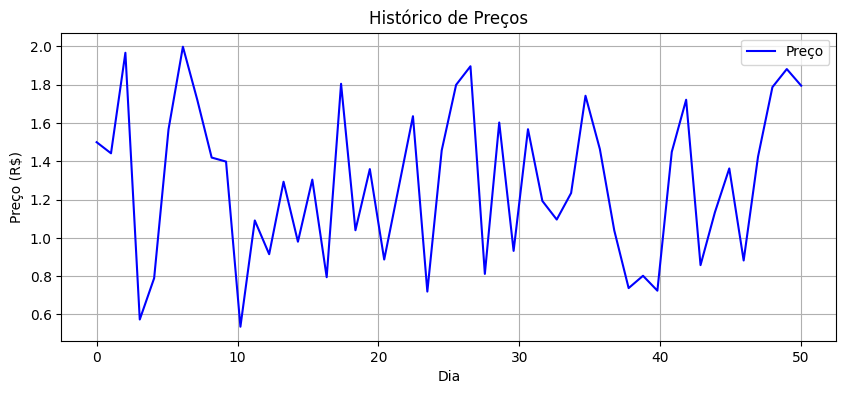

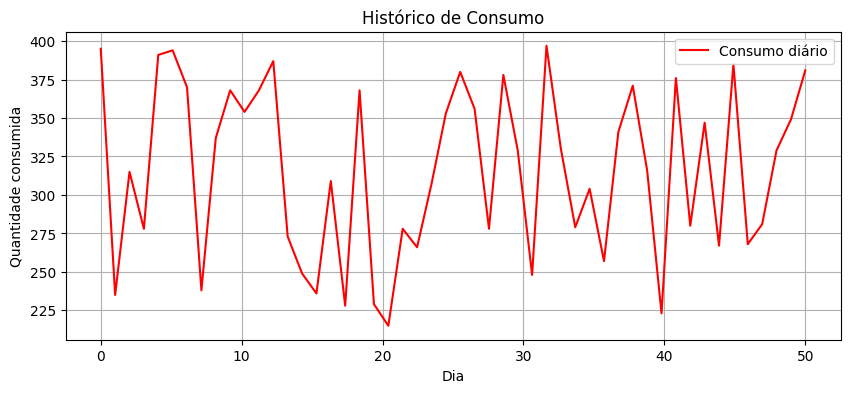

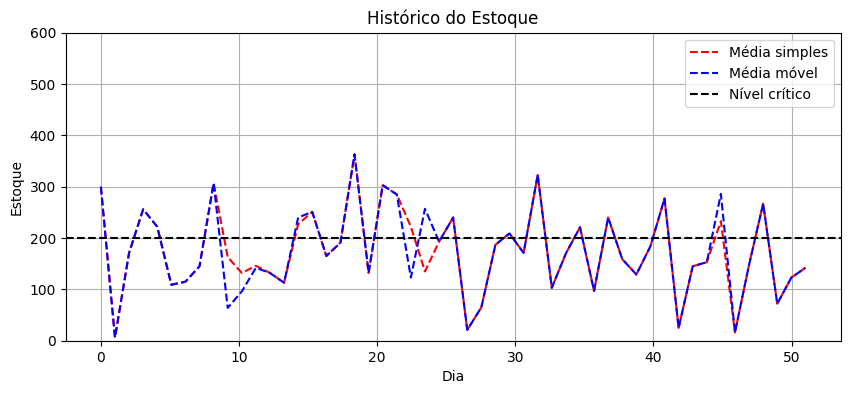


Custos de cada estratégia:
Custo total com média simples: R$ 20219.39
Custo total com média móvel : R$ 20329.26


In [ ]:
ambiente = Ambiente()

agente = Agente(ambiente)

agente.executa_agente(qtde_dias=50)

Imprime.imprime_resultado(agente)